# Data generation and animation simulation
___
last updated : 0518

In [1]:
import numpy as np; import pandas as pd; import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
%matplotlib inline

## A. Decision boundary
- Simualated boundary

    |        | before drift (DB1)         | after drift (DB2)           |
    |--------|----------------------------|-----------------------------|
    | sine   | sin(x)                     | reverted                    |
    | circle | xc, yc, rc = 0.4, 0.5, 0.2 | x1c, x2c, rc = 0.6,0.5,0.25 |
    | sea    | x+y = 7                    | x+y = 3                     |

In [2]:
class DecisionBoundary:
    "generates 2d simulation dataset"
    def __init__(self, size, seed):
        self.size = size
        self.seed = seed
        self.random_state = np.random.RandomState(seed)
    
    ## Circles data set
    def Circles(self, xc, yc, rc, border=0):
        """
        support : 0<= x, y <=1
        boundary : inside circle == positive
        parameters : xc, yc, rc 
        """
        ## support
        df = pd.DataFrame(self.random_state.rand(self.size,2))
        df = df.rename(columns={0:'x', 1:'y'})
        ## classification 
        f = lambda x: 1.0 if (x['x']-xc)**2 + (x['y']-yc)**2 <=rc else 0.0
        ## labeling
        df['class'] = df.apply(f, axis=1)
        ## borderline
        b = lambda x: 1.0 if abs((x['x']-xc)**2 + (x['y']-yc)**2-rc) <= border else 0.0
        df['border'] = df.apply(b,axis=1)
        
        return df
    
    ## Sine dataset
    def Sine(self, revert=False, border=0):
        """
        support : 0<= x <= 2pie, -1<= y <=1
        boundary : y < sin(x)
        rescaled : True, x,y in (0,1)
        """
        ## support
        x_array = self.random_state.uniform(low=0, high=2*np.pi,size=self.size)
        y_array = self.random_state.uniform(low=-1, high=1,size=self.size)
        df = pd.DataFrame({'x':x_array, 'y':y_array})
        # classification
        f = lambda x: 1.0 if x['y'] < np.sin(x['x']) else 0.0
        if revert:
            f = lambda x: 1.0 if x['y'] > np.sin(x['x']) else 0.0
        ## labeling
        df['class'] = df.apply(f, axis=1)
        ## borderline
        b = lambda x: 1.0 if abs(x['y'] - np.sin(x['x'])) <= .3 else 0.0
        df['border'] = df.apply(b,axis=1)
        ## normalise
        df[['x','y']] = df[['x','y']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
        
        return df
    
    ## SEA dataset
    def SEA(self, value, border=0):
        """
        support : 0<= x1, x2 <=10
        boundary : x1+x2 <= value 
        rescaled : True, x1,x2 (0,1)
        """
        ## support
        x_array = self.random_state.uniform(low=0, high=10,size=self.size)
        y_array = self.random_state.uniform(low=0, high=10,size=self.size)
        df = pd.DataFrame({'x':x_array, 'y':y_array})
        # classification
        f = lambda x: 1.0 if x['x'] + x['y'] <= value else 0.0
        ## labeling
        df['class'] = df.apply(f, axis=1)
        ## borderline
        b = lambda x: 1.0 if abs(x['x'] + x['y']-value) <= border else 0.0
        df['border'] = df.apply(b,axis=1)
        ## normalise
        df[['x','y']] = df[['x','y']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
        
        return df

In [3]:
# my database
DB1 =DecisionBoundary(size=20000, seed=0)
DB2 =DecisionBoundary(size=20000, seed=1)

In [4]:
%%time
## before
df1 = DB1.Circles(xc=0.4, yc=0.5, rc=0.2)
df2 = DB1.Sine(revert=False)
df3 = DB1.SEA(value=7)
## after
df4 = DB2.Circles(xc=0.6, yc=0.5, rc=0.25)
df5 = DB2.Sine(revert=True)
df6 = DB2.SEA(value=3)

Wall time: 4.71 s


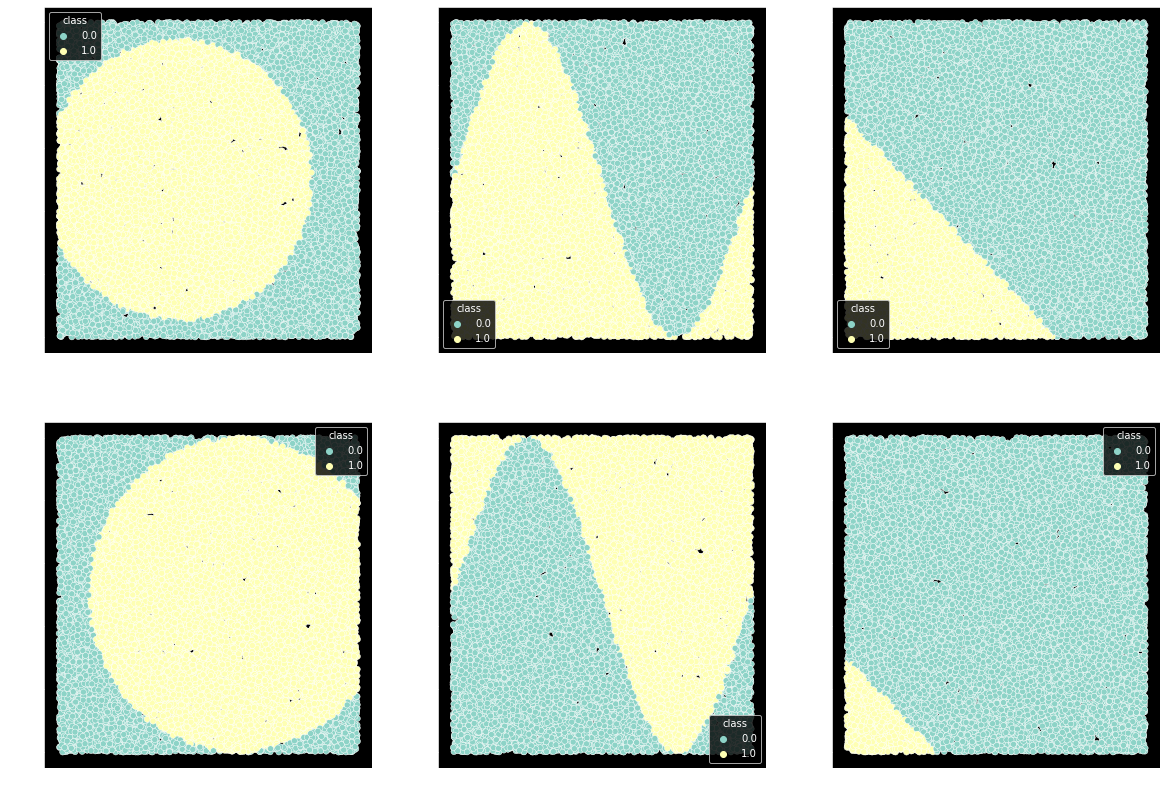

In [5]:
## visual check
fig, ax = plt.subplots(2,3, figsize=(20,14))
for i, v in enumerate([df1, df2, df3, df4, df5, df6]):
    sns.scatterplot(data = v, x = 'x', y = 'y', hue="class", ax=ax[i//3][i%3])

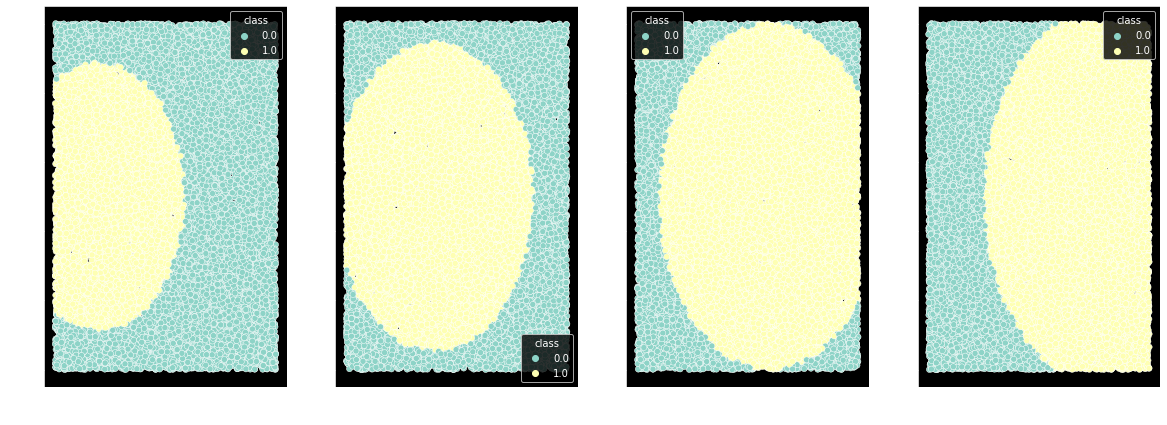

In [6]:
## circles ref>>
c1 = DB1.Circles(xc=0.2, yc=0.5, rc=0.15)
c2 = DB1.Circles(xc=0.4, yc=0.5, rc=0.2)
c3 = DB1.Circles(xc=0.6, yc=0.5, rc=0.25)
c4 = DB1.Circles(xc=0.8, yc=0.5, rc=0.3)

fig, ax = plt.subplots(1,4, figsize=(20,7))
for i, v in enumerate([c1, c2, c3, c4]):
    sns.scatterplot(data = v, x = 'x', y = 'y', hue="class", ax=ax[i])

## B. Imbalance type

- noise
- borderline

### Noise generator

In [7]:
def noise(data, prob_noise, seed=0):
    """
    >> generate noise with probability
        
    data : target data
    prob_noise : noise probability
    seed : seed
        
    ** warning : the original should be large enough to not be empty while sampling **
    """
    df = data.copy()
    ## noise candidate
    candidate = df.sample(frac=prob_noise, random_state=seed).index.to_list()
    ## generate noise
    n = lambda x: abs(x['class']-1)
    df.loc[df.index.isin(candidate),'class'] = df.apply(n,axis=1)
    return df

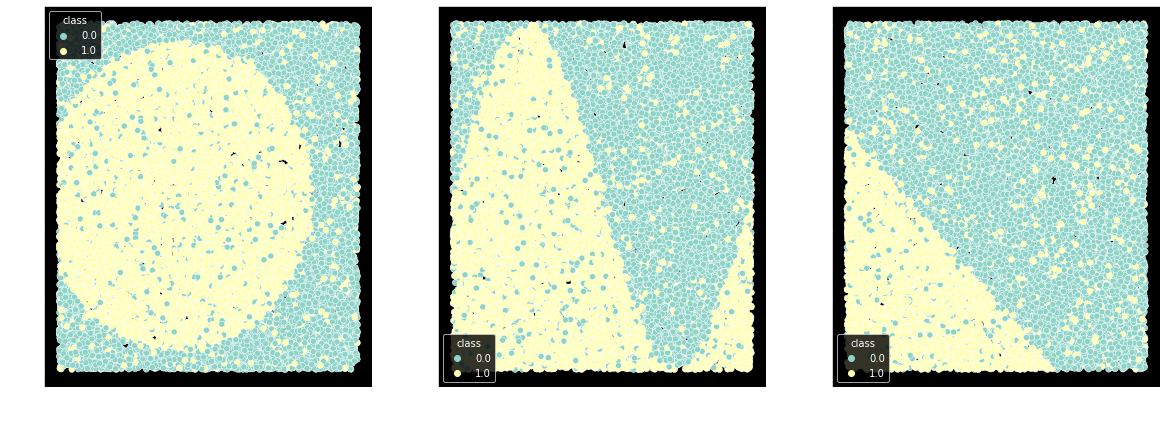

In [8]:
## visual check
fig, ax = plt.subplots(1,3, figsize=(20,7))
for i, v in enumerate([noise(df1, 0.1), noise(df2, 0.1), noise(df3, 0.1)]):
    sns.scatterplot(data = v, x = 'x', y = 'y', hue="class", ax=ax[i])

### Borderline dataset
- recreate stationary data with border indicator (and bigger size)
    - circle : 0.05
    - sine : 0.3
    - sea : 0.7
- generate 30% of noise near borderline
- resample data with desired size
    - total size = 10000
    - borderline (60%)

In [10]:
%%time
## before
t1 = DBb.Circles(xc=0.4, yc=0.5, rc=0.2, border=0.05)
t2 = DBb.Sine(revert=False, border=0.3)
t3 = DBb.SEA(value=7, border=0.7)
## after
t4 = DBb.Circles(xc=0.6, yc=0.5, rc=0.25, border=0.05)
t5 = DBb.Sine(revert=True, border=0.3)
t6 = DBb.SEA(value=3, border=0.7)

Wall time: 3min 48s


In [11]:
def borderline(data, size=20000, pr=0.55):
    dt = data.copy()
    b_size = round(size*(pr))
    dt_n = dt[dt['border']==0].sample(n=(size-b_size), replace=False)
    dt_b = dt[dt['border']==1].sample(n=b_size, replace=False)
    dt_b = noise(dt_b, 0.2)
    
    fin = pd.concat([dt_b, dt_n],axis=0).reset_index(drop=True)
    fin=fin.iloc[np.random.permutation(fin.index)].reset_index(drop=True)
    return fin

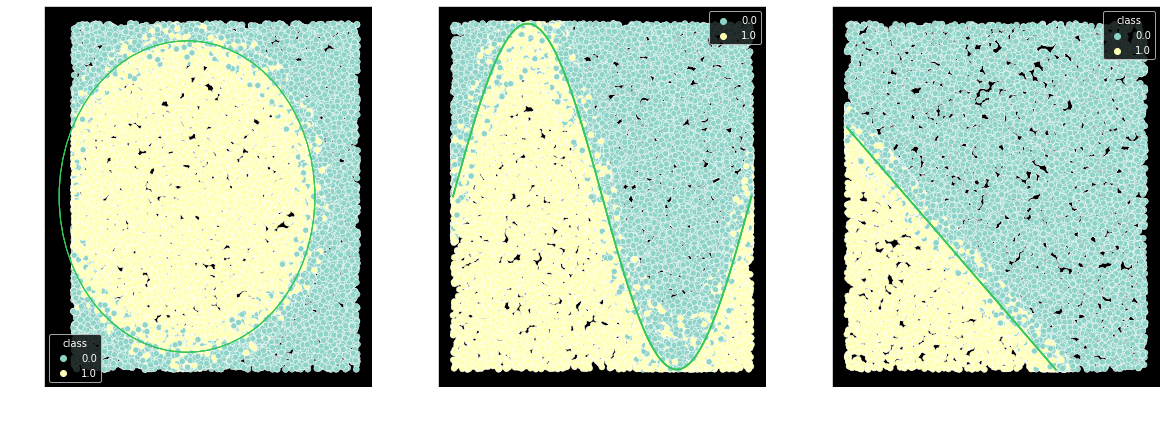

In [12]:
## visual check
import matplotlib.patches as patches
%matplotlib inline
## sine_line
scaler = lambda x : (x+1)/2
x = np.linspace(0,1,100); y = np.sin(2*np.pi*x) ; y_s = scaler(y)
sine_line = pd.DataFrame(np.c_[x,y_s])

fig, ax = plt.subplots(1,3, figsize=(20,7))
for i, v in enumerate([borderline(t1), borderline(t2), borderline(t3)]):
    sns.scatterplot(data = v, x = 'x', y = 'y', hue="class", ax=ax[i])
    ax[0].add_patch(patches.Circle((0.4, 0.5), 0.45, edgecolor="#34c759", linestyle='solid',fill=False))
    sns.lineplot(x=x, y=y_s, data=sine_line, color = '#34c759', ax=ax[1])
    ax[2].plot([0.7, 0], [0, 0.7], color="#34c759", linestyle='solid')

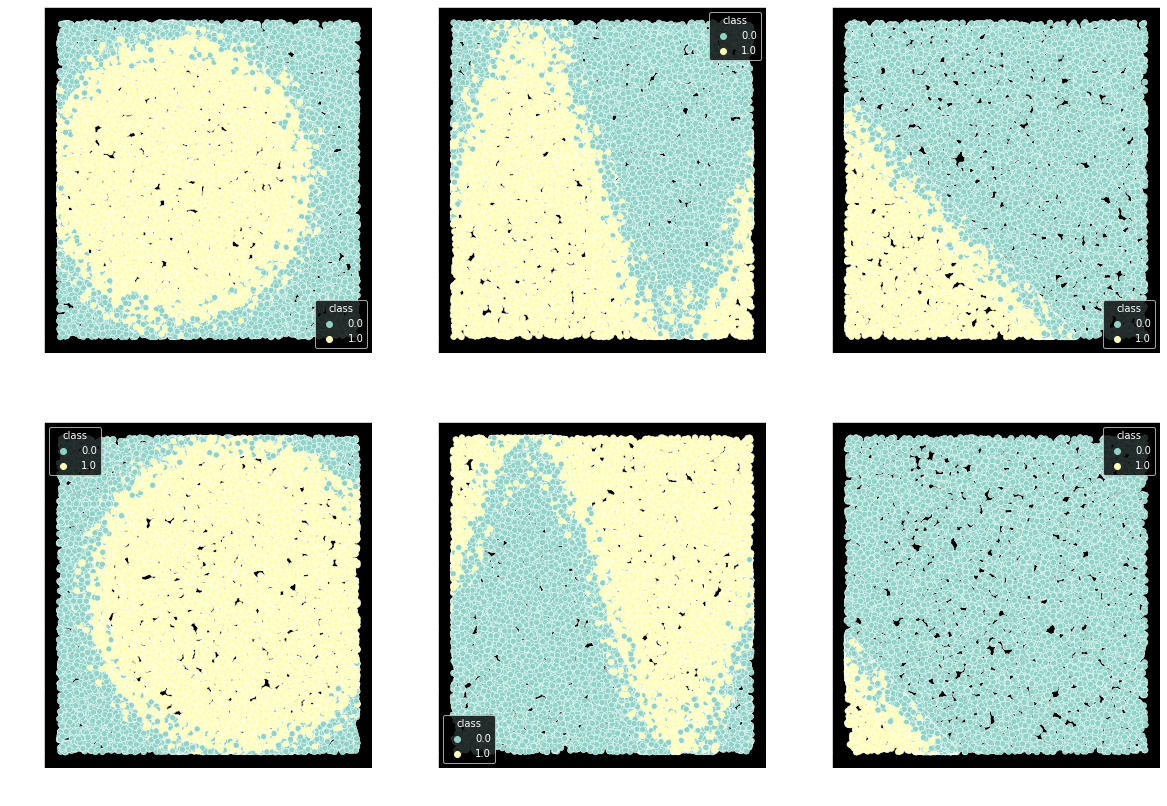

In [13]:
## visual check
fig, ax = plt.subplots(2,3, figsize=(20,14))
for i, v in enumerate([borderline(t1), borderline(t2), borderline(t3), borderline(t4), borderline(t5), borderline(t6)]):
    sns.scatterplot(data = v, x = 'x', y = 'y', hue="class", ax=ax[i//3][i%3])

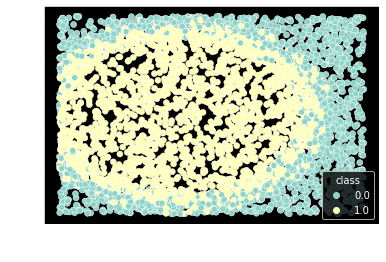

In [15]:
## sampled for 5000
sns.scatterplot(data = borderline(t1).sample(n=5000, replace=False), x = 'x', y = 'y', hue="class")

## C. Final Simulator
- final dataset (size=5000) simulator

In [16]:
def get_one(df, random_state):
    "random sampling without replacement"
    idx = random_state.choice(range(df.shape[0]))
    one = df.iloc[idx,:]
    df_left = df.drop(idx, axis=0).reset_index(drop=True)
    return one, df_left

def simulation_data(random_state, time_steps, time_drift, boundary, ir, imbtype):
    #--------------------initailise--------------------#    
    dic = r'C:\Users\CCNI\Danstat\thesis\0518\data'
    os.chdir(dic)
    
    #--------------------data setting--------------------#
    ## before drift
    df = borderline(t1) ; df2 = borderline(t4)
    #df1 = pd.read_csv(f'{boundary}_before.csv')
    #df2 = pd.read_csv(f'{boundary}_after.csv')
    
    ## divide into classes
    df_neg = df[df['class']==0].reset_index(drop=True)
    df_pos = df[df['class']==1].reset_index(drop=True)
    
    df_neg2 = df2[df2['class']==0].reset_index(drop=True)
    df_pos2 = df2[df2['class']==1].reset_index(drop=True)

    ## result    
    res = []
    
    for t in range(time_steps):

    #--------- concept drift --------------#
        if t == time_drift:
            df_neg = df_neg2
            df_pos = df_pos2
            
    #---------- sampling ------------#
        # negative example
        if random_state.rand() > ir: 
            one, df_neg = get_one(df_neg, random_state)
        # positive example
        else: 
            one, df_pos = get_one(df_pos, random_state) 
        ## store 
        res.append(one)
       
    res = pd.DataFrame(res).reset_index(drop=True)
    
    return res

In [17]:
sim_data = simulation_data(random_state = np.random.RandomState(100), time_steps =5000, time_drift =2500, boundary='s', ir=0.1, imbtype='safe')

Text(0.5, 1.0, 'drifted')

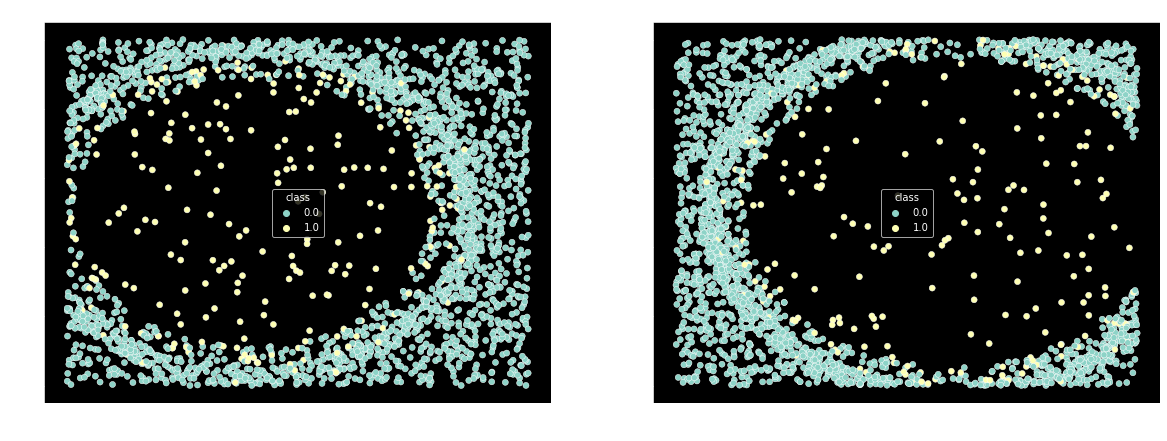

In [18]:
# visual check with 5000 points
ncols = 2
fig, ax = plt.subplots(1,ncols, figsize=(20,7))

for i, v in enumerate([sim_data[:2500],sim_data[2500:]]):
    sns.scatterplot(data = v, x = 'x', y = 'y', hue="class", ax=ax[i])
    
ax[0].set_title('original')
ax[1].set_title('drifted')

## D. Save

In [26]:
dic = r'C:\Users\CCNI\Danstat\thesis\0518\data'
os.chdir(dic)
# ----------- safe/noise -----------#
## before
df1.drop('border',axis=1).to_csv('circle.csv', index=False)
df2.drop('border',axis=1).to_csv('sine.csv', index=False)
df3.drop('border',axis=1).to_csv('sea.csv', index=False)
## after
df4.drop('border',axis=1).to_csv('circle2.csv', index=False)
df5.drop('border',axis=1).to_csv('sine2.csv', index=False)
df6.drop('border',axis=1).to_csv('sea2.csv', index=False)
# ----------- borderline -----------#
borderline(t1).drop('border',axis=1).to_csv('circle_b.csv', index=False)
borderline(t2).drop('border',axis=1).to_csv('sine_b.csv', index=False)
borderline(t3).drop('border',axis=1).to_csv('sea_b.csv', index=False)
## after
borderline(t4).drop('border',axis=1).to_csv('circle_b2.csv', index=False)
borderline(t5).drop('border',axis=1).to_csv('sine_b2.csv', index=False)
borderline(t6).drop('border',axis=1).to_csv('sea_b2.csv', index=False)

## E. Animated
- online setting animation
    - reference : https://youtu.be/dOKHY_PUvqU
    - reference : https://stackoverflow.com/questions/43044454/different-color-points-from-an-array-in-matplotlib-animation

In [25]:
from matplotlib.animation import FuncAnimation
%matplotlib qt

fig, ax = plt.subplots(figsize=(7,7))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

data = sim_data

# update
def update(i):
    line = sns.scatterplot(data = data[:i], x = 'x', y = 'y', hue="class",legend=False)
    return line,

ani = FuncAnimation(fig, update, frames=len(df3), interval=0.1)
plt.show()